In [1]:
import os

# Change the working directory
os.chdir("/Users/pavan/Downloads/Project")

# Verify the current working directory
current_working_directory = os.getcwd()
print("Current Working Directory:", current_working_directory)

Current Working Directory: /Users/pavan/Downloads/Project


In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import hour, col, mean, stddev

spark = SparkSession.builder.appName("NYTaxiEDA").getOrCreate()

data = spark.read.csv("taxi-data-sorted-small (1).csv", header=False, inferSchema=True)
column_names = [
    "medallion", "hack_license", "pickup_datetime", "dropoff_datetime", "trip_time_in_secs",
    "trip_distance", "pickup_longitude", "pickup_latitude", "dropoff_longitude", 
    "dropoff_latitude", "payment_type", "fare_amount", "surcharge", "mta_tax",
    "tip_amount", "tolls_amount", "total_amount"
]
for i, column_name in enumerate(column_names):
    data = data.withColumnRenamed(f"_c{i}", column_name)
data.show(5)

+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|    pickup_datetime|   dropoff_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|07290D3599E7A0D62...|E7750A37CAB07D0DF...|2013-01-01 00:00:00|2013-01-01 00:02:00|              120|         0.44|      -73.956528|      40.716976|        -73.96244|       40.715008|         CSH|        3.5|

In [4]:
cols_to_check = ["trip_time_in_secs", "trip_distance", "surcharge", "fare_amount"]

# Identify and remove outliers using 1.5*IQR method for the selected columns
for col_name in cols_to_check:
    q1, q3 = data.approxQuantile(col_name, [0.25, 0.75], 0.01)  # Get Q1 and Q3
    iqr = q3 - q1  # Calculate IQR
    lower_bound = q1 - 1.5 * iqr  # Get lower bound
    upper_bound = q3 + 1.5 * iqr  # Get upper bound
    # Filter data by removing outliers
    data = data.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

In [5]:
# Count null values per column
null_counts = {col: data.filter(data[col].isNull()).count() for col in data.columns}
print(null_counts)

{'medallion': 0, 'hack_license': 0, 'pickup_datetime': 0, 'dropoff_datetime': 0, 'trip_time_in_secs': 0, 'trip_distance': 0, 'pickup_longitude': 0, 'pickup_latitude': 0, 'dropoff_longitude': 0, 'dropoff_latitude': 0, 'payment_type': 0, 'fare_amount': 0, 'surcharge': 0, 'mta_tax': 0, 'tip_amount': 0, 'tolls_amount': 0, 'total_amount': 0}


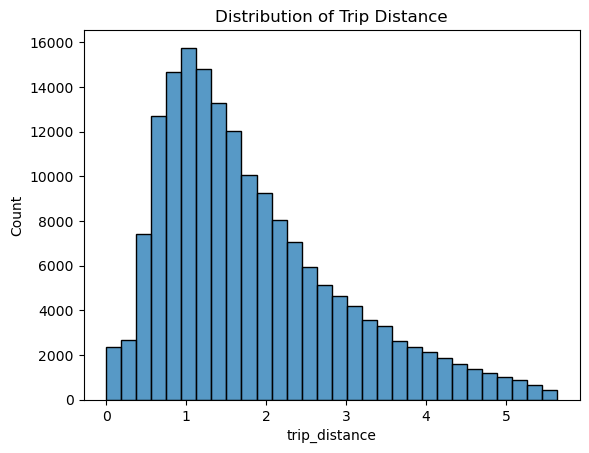

In [6]:
sampled_data = data.select("trip_distance").sample(False, 0.1).toPandas()
sns.histplot(data=sampled_data, x="trip_distance", bins=30)
plt.title('Distribution of Trip Distance')
plt.show()

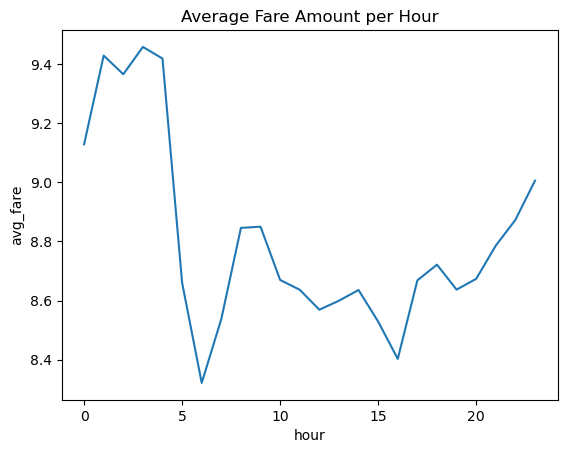

In [7]:
data_with_hour = data.withColumn("hour", hour(data["pickup_datetime"]))
hourly_avg_fare = data_with_hour.groupBy("hour").agg(mean("fare_amount").alias("avg_fare")).toPandas()

sns.lineplot(data=hourly_avg_fare, x="hour", y="avg_fare")
plt.title('Average Fare Amount per Hour')
plt.show()

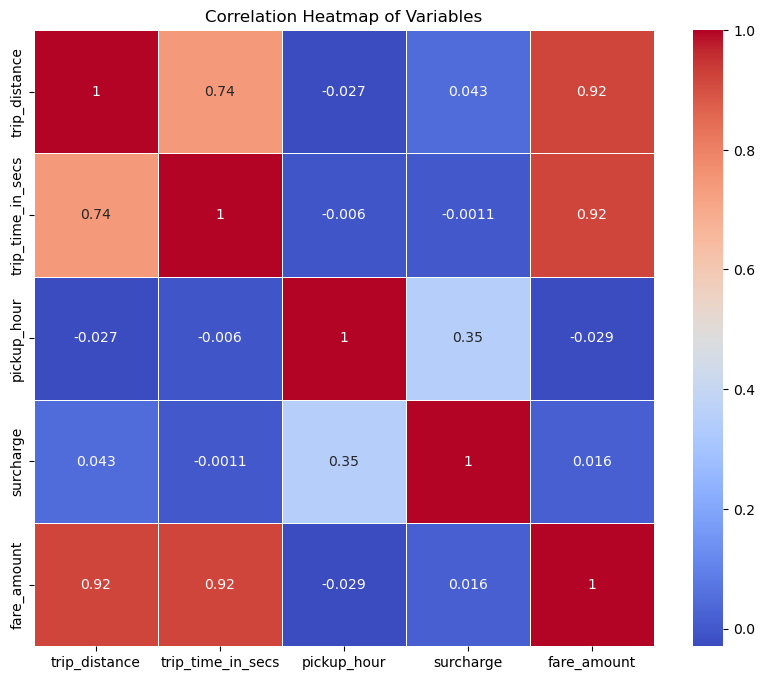

In [8]:
data = data.withColumn("pickup_hour", hour(data["pickup_datetime"]))

# If your data is too large to bring into Pandas all at once, consider sampling or aggregating in some way before converting to Pandas DataFrame
sample_data = data.sample(False, 0.01).toPandas()  # taking 1% of data

# Calculate correlations in Pandas
heatmap_data = sample_data[['trip_distance', 'trip_time_in_secs', 'pickup_hour', 'surcharge', 'fare_amount']]
correlations = heatmap_data.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of Variables')
plt.show()

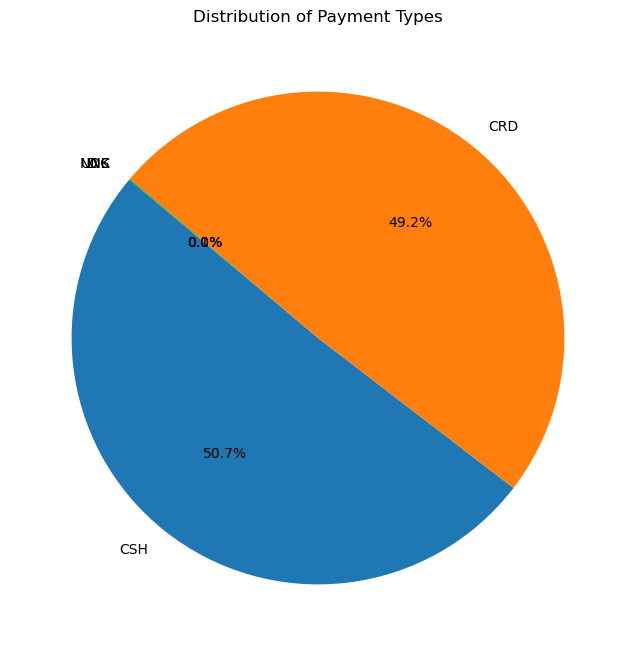

In [9]:
payment_type_pandas = data.select("payment_type").toPandas()

# Generate pie chart
payment_counts = payment_type_pandas['payment_type'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(payment_counts, labels = payment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Payment Types')
plt.show()

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [11]:
feature_columns = ["trip_distance", "pickup_hour", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

In [12]:
lr = LinearRegression(labelCol="fare_amount", featuresCol="features")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

23/10/12 13:09:29 WARN Instrumentation: [3f470362] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 13:09:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/12 13:09:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [13]:
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 1.3756471056022814


In [19]:
from pyspark.sql.functions import min, max

# Compute min and max of fare_amount
min_max_values = data.agg(
    min(col("fare_amount")).alias("min_fare_amount"),
    max(col("fare_amount")).alias("max_fare_amount")
).collect()

min_value = min_max_values[0]["min_fare_amount"]
max_value = min_max_values[0]["max_fare_amount"]

print(f"Minimum fare amount: ${min_value}")
print(f"Maximum fare amount: ${max_value}")



Minimum fare amount: $2.5
Maximum fare amount: $18.5


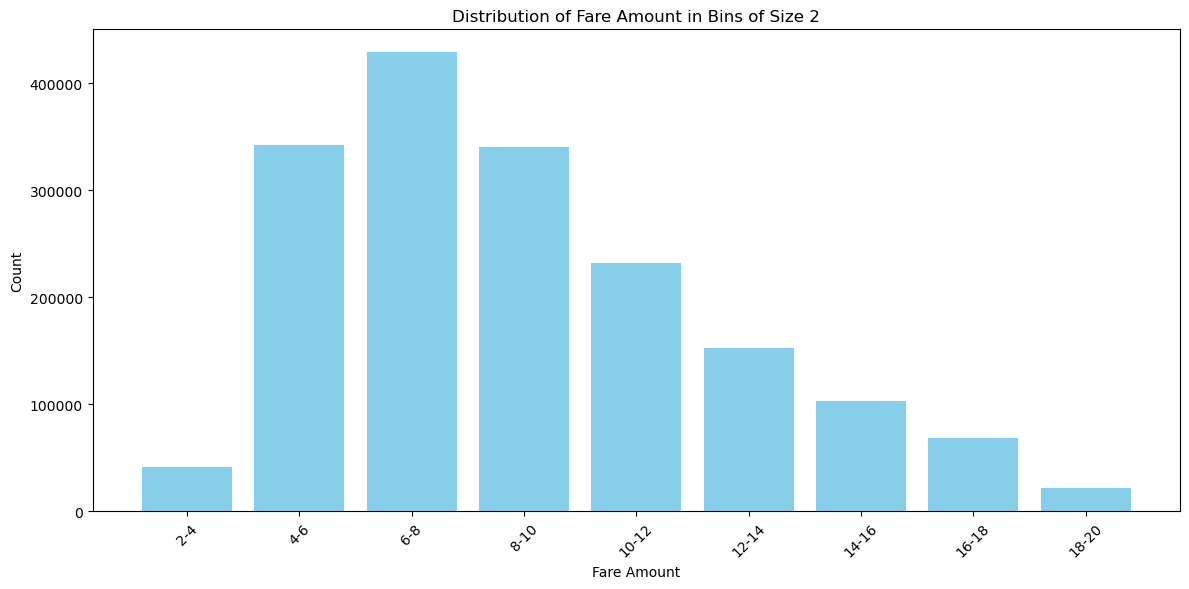

In [20]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import Bucketizer

# Step 1: Binning the fare_amount
max_fare = data.agg({"fare_amount": "max"}).collect()[0][0]
bucketizer = Bucketizer(splits=[i for i in range(0, int(max_fare) + 3, 2)], inputCol="fare_amount", outputCol="fare_bin")
data_with_bins = bucketizer.transform(data)

# Step 2: Counting the number of entries in each bin
bin_counts = data_with_bins.groupBy("fare_bin").count().orderBy("fare_bin").collect()

# Extracting bin ranges and counts for plotting
bins = [f"{int(row['fare_bin']*2)}-{int(row['fare_bin']*2 + 2)}" for row in bin_counts]
counts = [row['count'] for row in bin_counts]

# Step 3: Plotting the bar plot
plt.figure(figsize=(12, 6))
plt.bar(bins, counts, color='skyblue')
plt.xlabel('Fare Amount')
plt.ylabel('Count')
plt.title('Distribution of Fare Amount in Bins of Size 2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
from pyspark.sql.functions import count, avg, sum
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [22]:
driver_metrics = data.groupBy("hack_license").agg(
    sum("total_amount").alias("total_fare_earned"),
    count("medallion").alias("number_of_trips"),
    avg("tip_amount").alias("avg_tip_received")
)

driver_metrics.show(5)

+--------------------+------------------+---------------+------------------+
|        hack_license| total_fare_earned|number_of_trips|  avg_tip_received|
+--------------------+------------------+---------------+------------------+
|130328475AD7427AF...|           1062.38|            100|            1.0638|
|D4F2AE0988ECB2E42...|           1757.93|            153|1.0629411764705883|
|DD97899ACAC51EF31...|            215.55|             19| 1.186842105263158|
|A7C47E60941315A0E...|           2177.97|            202|0.8389603960396042|
|9911D66A4A796752D...|1523.8999999999999|            133|1.0067669172932332|
+--------------------+------------------+---------------+------------------+
only showing top 5 rows



In [24]:
feature_cols = ["total_fare_earned", "number_of_trips", "avg_tip_received"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
feature_data = assembler.transform(driver_metrics)

# K-Means clustering
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="cluster")  # 3 clusters as an example
model = kmeans.fit(feature_data)
clustered_data = model.transform(feature_data)

# Show the resulting clusters
clustered_data.select("hack_license", "cluster").show(5)

+--------------------+-------+
|        hack_license|cluster|
+--------------------+-------+
|130328475AD7427AF...|      0|
|D4F2AE0988ECB2E42...|      2|
|DD97899ACAC51EF31...|      1|
|A7C47E60941315A0E...|      2|
|9911D66A4A796752D...|      2|
+--------------------+-------+
only showing top 5 rows



In [25]:
cols_to_check = ["total_fare_earned", "number_of_trips", "avg_tip_received"]

for col_name in cols_to_check:
    q1, q3 = driver_metrics.approxQuantile(col_name, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    anomalies = driver_metrics.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))
    
    print(f"Anomalies in {col_name}:")
    anomalies.show()

Anomalies in total_fare_earned:


+--------------------+------------------+---------------+------------------+
|        hack_license| total_fare_earned|number_of_trips|  avg_tip_received|
+--------------------+------------------+---------------+------------------+
|F49FD0D84449AE7F7...|            4306.5|            434|0.7935483870967742|
|97F7B431B057B98EA...|3757.8899999999994|            356|0.9266573033707863|
|9E035DBF346FDE01F...|3856.4900000000002|            377|0.8156233421750662|
|51C1BE97280A80EBF...| 4232.239999999999|            411|0.9110462287104623|
|DB1B4490DA4A46A7A...|           4400.29|            411| 0.827712895377129|
|C9674190984BA193F...|           3810.64|            363|0.7948760330578513|
+--------------------+------------------+---------------+------------------+



Anomalies in number_of_trips:


+--------------------+------------------+---------------+-------------------+
|        hack_license| total_fare_earned|number_of_trips|   avg_tip_received|
+--------------------+------------------+---------------+-------------------+
|F49FD0D84449AE7F7...|            4306.5|            434| 0.7935483870967742|
|97F7B431B057B98EA...|3757.8899999999994|            356| 0.9266573033707863|
|9E035DBF346FDE01F...|3856.4900000000002|            377| 0.8156233421750662|
|9112D33A328C37CF6...|3558.5899999999997|            351| 0.8364387464387464|
|51C1BE97280A80EBF...| 4232.239999999999|            411| 0.9110462287104623|
|DB1B4490DA4A46A7A...|           4400.29|            411|  0.827712895377129|
|C9674190984BA193F...|           3810.64|            363| 0.7948760330578513|
|00B7691D86D96AEBD...|           2075.11|            489|0.10118609406952966|
+--------------------+------------------+---------------+-------------------+



Anomalies in avg_tip_received:


+--------------------+------------------+---------------+------------------+
|        hack_license| total_fare_earned|number_of_trips|  avg_tip_received|
+--------------------+------------------+---------------+------------------+
|B508465FAC4F54A40...|             113.5|             10|               0.0|
|A2AAF2102F3D8AF40...|              18.6|              1|               3.1|
|E9B0F9B61761F9F37...|              12.5|              1|               2.0|
|560DE283367A74CE6...|             15.62|              1|              3.12|
|EEDE57108D76F5B35...|              23.4|              2|              1.95|
|685E69EDB24986567...|              16.0|              1|               1.5|
|D8856767BB390CD43...|              37.5|              3|1.8333333333333333|
|4215A39B9D316E2D7...|1612.8899999999999|            147|1.5434693877551022|
|C2A4BD9771B4A78B4...|              19.0|              2|              1.75|
|CAD29CEA4D2A2B5EA...|              23.0|              2|              1.75|

In [26]:
spark.stop()
